## Homework 5

In [61]:
## Task 1.
# Importing libraries
# my functions
from modules.basis_functions import *
from modules.ransac import *
from modules.visualization import plot_periodic_data
# Machine learning libraries
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

#pipelines
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
# metrics
from sklearn.metrics import mean_squared_error

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# data manipulation
import pandas as pd

# visualization
from prettytable import PrettyTable



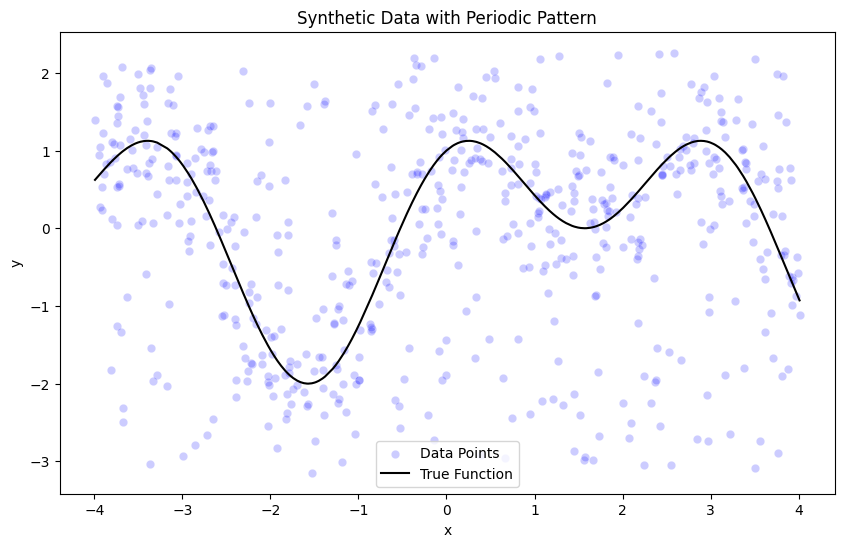

In [62]:
# Step 1: Generate data
x,y = generate_data_synthetic_periodic(N=600, percent_outliers_size=0.40, x_min=-4,x_max=4)

# visualization the synthetic data
y_true = compute_y_true(x)
plot_periodic_data(x,y,y_true)

# x and y, taken the shape N+outliers_size,1

In [63]:
# %% Setting parameters for the experiments
 
# Setting the number of terms in the series fourier

num_term_series=3

# Parameters of RANSAC
n_sample = 100

threshold = 0.1

iterations = 1000

alpha =1

# model of regression
model_hipotesis = Ridge(alpha=alpha)
#model_hipotesis = LinearRegression()


In [64]:
# Traditional Linear Regression

# pipeline
my_transformation = FunctionTransformer(fourier_basis,kw_args={'num_terms':num_term_series})

pipeline = make_pipeline(my_transformation,Ridge(alpha=alpha))
#pipeline = make_pipeline(my_transformation,LinearRegression())

# filter
pipeline.fit(x,y)

#prediction
y_pred = pipeline.predict(x)  


## Experiments With Ransac

In this section are showed the results of the parameters estimation with the algorithm Ransac

In [65]:

# setting the number of terms in the series fourier and applied the transformation
X_transformed = fourier_basis(x, num_terms=num_term_series)


# Parameters for the RANSAC algorithm

data = X_transformed



best_parameters,worst_parameters = ransac(X_transformed,y,iterations=iterations,n_sample=n_sample,threshold=threshold,model=model_hipotesis) 

y_pred_ransac_best = np.dot(X_transformed, best_parameters)
y_pred_ransac_worst = np.dot(X_transformed, worst_parameters)

Best model updated with 68 inliers
Min model updated with 23 inliers


In [66]:
## Get the coefficientes
coefficients_lr = pipeline.named_steps['ridge'].coef_
#coefficients_lr = pipeline.named_steps['linearregression'].coef_
coefficients_ransac_best = best_parameters
cooefficients_ransac_worst = worst_parameters


## Compute the Metrics

In [67]:
mse_linear_regression = mean_squared_error(y, y_pred)
rsme_linear_regression = np.sqrt(mse_linear_regression) 

table = PrettyTable()

# Add columns
table.field_names = ["Model", "MSE", "RMSE"]

# Add data
table.add_row(["Linear Regression", mse_linear_regression, rsme_linear_regression])
table.add_row(["Best Model with Ransac", mean_squared_error(y, y_pred_ransac_best), np.sqrt(mean_squared_error(y, y_pred_ransac_best))])
table.add_row(["Worst Model with Ransac", mean_squared_error(y, y_pred_ransac_worst), np.sqrt(mean_squared_error(y, y_pred_ransac_worst))])

# Print the table
print(table)

+-------------------------+--------------------+--------------------+
|          Model          |        MSE         |        RMSE        |
+-------------------------+--------------------+--------------------+
|    Linear Regression    | 1.4771606413332454 | 1.2153849765951714 |
|  Best Model with Ransac | 1.5978502028354622 | 1.2640609964853209 |
| Worst Model with Ransac | 1.7078693465545722 | 1.306854753426934  |
+-------------------------+--------------------+--------------------+


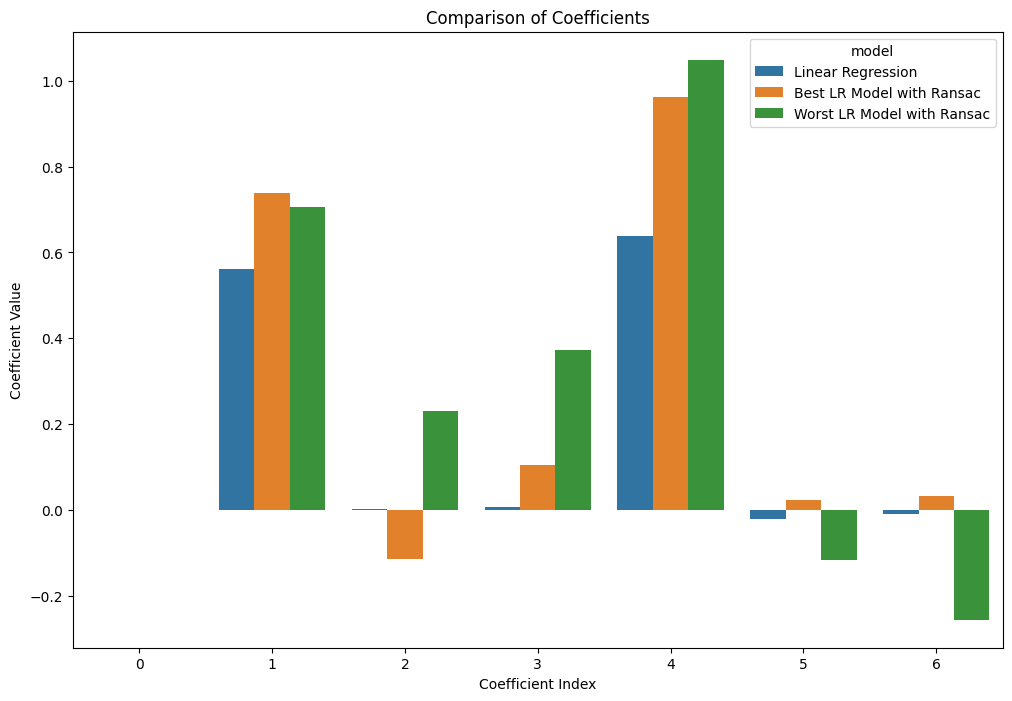

In [68]:
## Dataframe of coefficientes
# Create a list of tuples
data_coefficients = list(zip(['Linear Regression']*len(coefficients_lr) + ['Best LR Model with Ransac']*len(coefficients_ransac_best) 
+ ['Worst LR Model with Ransac']*len(cooefficients_ransac_worst),
                np.concatenate([coefficients_lr, coefficients_ransac_best, cooefficients_ransac_worst])))

# Convert the list to a DataFrame
df = pd.DataFrame(data_coefficients, columns=['model', 'coefficient'])

# Now you can plot the data
# Add a new column for the coefficient index
df['coefficient_index'] = list(range(len(coefficients_lr))) * 3

# Now you can plot the data
plt.figure(figsize=(12, 8))
sns.barplot(x='coefficient_index', y='coefficient', hue='model', data=df)
plt.title('Comparison of Coefficients')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.savefig(f'coefficients_{num_term_series}_ridge.png')
plt.show()

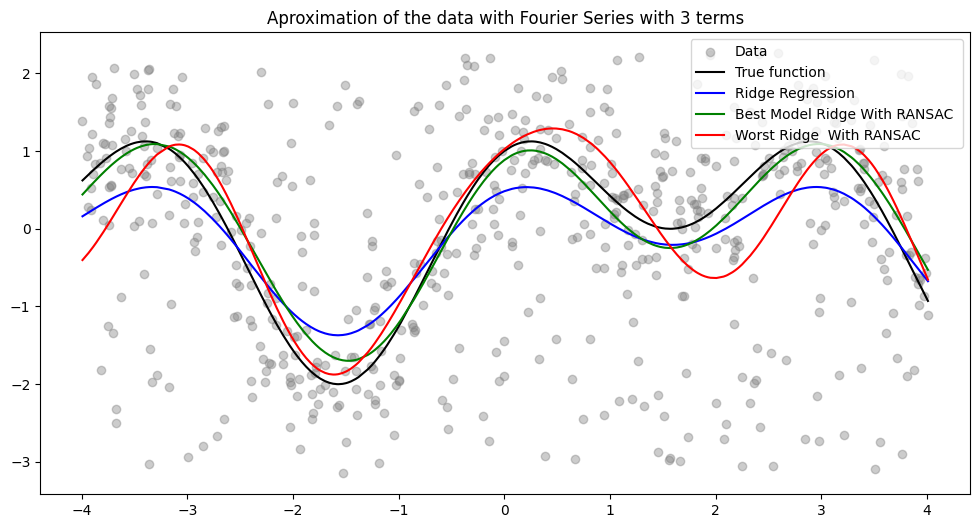

In [70]:
# Visualization LinearRegression
# Sorted de data

sorted_indices= np.argsort(x)
x_sorted = x[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]

y_true_sorted = y_true[sorted_indices]

y_pred_ransac_sorted = y_pred_ransac_best[sorted_indices]
y_pred_ransac_worst_sorted = y_pred_ransac_worst[sorted_indices]

# Plot the original data and the fitted line
plt.figure(figsize=(12, 6))
plt.scatter(x, y, color='gray',label='Data',alpha=0.4)
plt.plot(x_sorted,y_true_sorted, color='black', label='True function')
plt.plot(x_sorted,y_pred_sorted, color='blue', label='Ridge Regression')
plt.plot(x_sorted,y_pred_ransac_sorted, color='green', label='Best Model Ridge With RANSAC ')
plt.plot(x_sorted,y_pred_ransac_worst_sorted, color='red', label='Worst Ridge  With RANSAC')


plt.title(f'Aproximation of the data with Fourier Series with {num_term_series} terms')
# Add the legend
plt.legend(loc='upper right')
plt.savefig(f'result_{num_term_series}_ridge.png')
plt.show()